# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 51kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

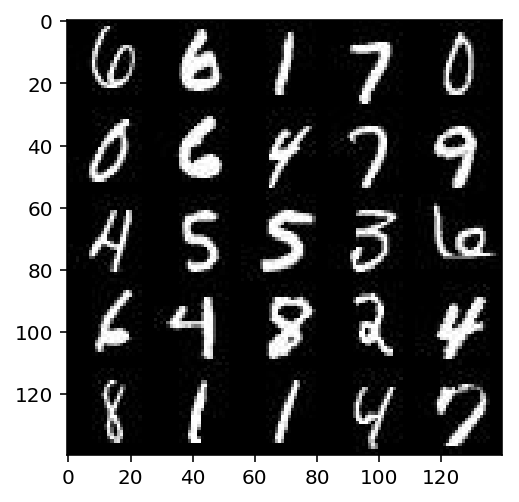

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

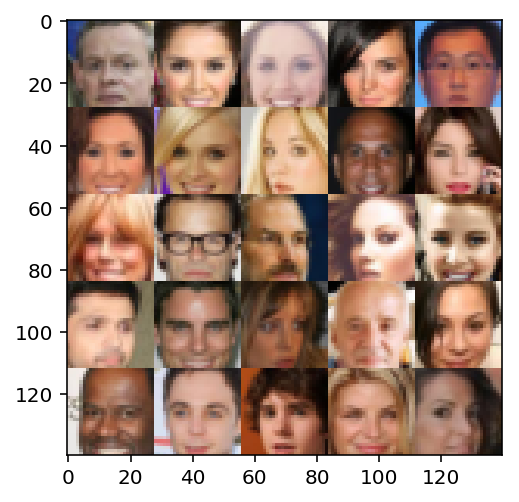

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [75]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # Alpha value for computing Leaky ReLU activations
    alpha = 0.2
    
    # Drop rate for dropout layers (layers 1 and 3 out of 
    # four total layers)
    drop_rate = 0.3
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Inputs will be of size 28 x 28 x dim_output_channel.
        # Do not use batch normalization on first conv layer, in order 
        # to avoid introducing weird artifacts into the images.
        layer_1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='same', activation=None)
        # Leaky ReLU activation
        lrelu1 = tf.maximum((alpha * layer_1), layer_1)
        lrelu1 = tf.layers.dropout(lrelu1, rate=drop_rate)
        # Shape now 14x14x64
        
        layer_2 = tf.layers.conv2d(lrelu1, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', activation=None)
        # Batch normalize all subsequent layers, save 
        # for the output layer. We are only interested in using the 
        # discriminator to help train the generator, so training 
        # parameter is set to True when calling tf.layers.batch_normalization.
        batch_norm2 = tf.layers.batch_normalization(layer_2, training=True)
        # Leaky ReLU activation
        lrelu2 = tf.maximum((alpha * batch_norm2), batch_norm2)
        # Shape now 7x7x128
        
        layer_3 = tf.layers.conv2d(lrelu2, filters=256, kernel_size=(5,5), strides=(2,2), padding='same', activation=None)
        # Batch normalize
        batch_norm3 = tf.layers.batch_normalization(layer_3, training=True)
        # Leaky ReLU activation
        lrelu3 = tf.maximum((alpha * batch_norm3), batch_norm3)
        lrelu3 = tf.layers.dropout(lrelu3, rate=drop_rate)
        # Shape now 4x4x256
        
        layer_4 = tf.layers.conv2d(lrelu3, filters=512, kernel_size=(5,5), strides=(2,2), padding='same', activation=None)
        # Batch normalize
        batch_norm4 = tf.layers.batch_normalization(layer_4, training=True)
        # Leaky ReLU activation
        lrelu4 = tf.maximum((alpha * batch_norm4), batch_norm4)
        # Shape now 2x2x512

        # Flatten final convolutional layer into a fully 
        # connected layer. Number of units in flat layer 
        # is equal to number of units in final convolutional 
        # layer (lrelu5).
        fully_connected = tf.reshape(lrelu4, [-1, 2*2*512])
        
        # Only one unit in logits because we are using 
        # a sigmoid function.
        logits = tf.layers.dense(inputs=fully_connected, units=1, activation=None)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [76]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # Alpha value for computing Leaky ReLU activations
    alpha = 0.2
    
    # Re-use generator variables when not training.
    if is_train:
        reuse = False
    else:
        reuse = True
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        
        # Fully connected input layer
        fc_input_layer = tf.layers.dense(z, 4*4*512, activation=None)
        
        # Reshape to start the convolutional stack
        layer1 = tf.reshape(fc_input_layer, [-1, 4, 4, 512])
        # batch normalize
        batch_norm1 = tf.layers.batch_normalization(inputs=layer1, training=is_train)
        # Leaky ReLU activation
        lrelu1 = tf.maximum((alpha * batch_norm1), batch_norm1)
        # Shape now 4x4x512
        
        # Initialize with Xavier initialization, use kernel size 
        # of 4, and padding of 'valid' in order to resize shape 
        # from 4x4x512 to 7x7x256.
        layer2 = tf.layers.conv2d_transpose(lrelu1, filters=256, kernel_size=(4,4), strides=(1,1), kernel_initializer=tf.contrib.layers.xavier_initializer(), padding ='valid')
        # batch normalize
        batch_norm2 = tf.layers.batch_normalization(inputs=layer2, training=is_train)
        # Leaky ReLU activation
        lrelu2 = tf.maximum((alpha * batch_norm2), batch_norm2)
        # Shape now 7x7x256
        
        layer3 = tf.layers.conv2d_transpose(lrelu2, filters=128, kernel_size=(5,5), strides=(2,2), padding='same')
        # batch normalize
        batch_norm3 = tf.layers.batch_normalization(inputs=layer3, training=is_train)
        # Leaky ReLU activation
        lrelu3 = tf.maximum((alpha * batch_norm3), batch_norm3)
        # Shape now 14x14x128
        
        layer4 = tf.layers.conv2d_transpose(lrelu3, filters=64, kernel_size=(5,5), strides=(2,2), padding='same')
        # batch normalize
        batch_norm4 = tf.layers.batch_normalization(inputs=layer4, training=is_train)
        # Leaky ReLU activation
        lrelu4 = tf.maximum((alpha * batch_norm4), batch_norm4)
        # Shape now 28x28x64
        
        # The output layer. No batch normalization nor activation 
        # function applied here.
        logits = tf.layers.conv2d_transpose(lrelu4, filters=out_channel_dim, kernel_size=(5,5), strides=(1,1), padding='same')
        # Shape now is 28 x 28 x out_channel_dim
        
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [77]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Generator model output 
    g_model_image_output = generator(input_z, out_channel_dim, is_train=True) 
    
    # Discriminator model outputs and logits for real and 
    # generated images.
    d_model_real_image_output, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake_image_output, d_logits_fake = discriminator(g_model_image_output, reuse=True) 
    
    # Discriminator loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real_image_output)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake_image_output)))
    d_loss = d_loss_real + d_loss_fake
    
    # Generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake_image_output)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [81]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get all trainable variables for both the discriminator 
    # and generator.
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    # Optimize
    # Start with tf.control_dependencies since we're using 
    # batch normalization.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [82]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [86]:
# How often to print out discriminator and generator loss
print_every = 100
# How often we display image samples created by the generator.
show_every = 500

# To plot the discriminator and generator losses at the end 
# of training.
losses = []

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_height = data_shape[1]
    image_width = data_shape[2]
    image_channels = data_shape[3]
    
    # Create input and learning rate placeholders
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Set the learning rate
    lr = learning_rate
    
    # Get the losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Get the optimizers
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # To count the number of batches trained on so far.
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                
                # Increase the iteration count by one each batch.
                steps += 1
                
                # Sample random noise for Generator input
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Real input images are in range [-0.5, 0.5]. They need to 
                # be scaled up to the range [-1,1]. This is because the 
                # generator will output images scaled between [-1,1].
                batch_images = batch_images * 2
                
                # Run the optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                # Print out loss and sample images created by the 
                # generator every print_every batches.
                if steps % print_every == 0:
                    # Get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                    print("Epoch {} of {}    ".format(epoch_i+1, epochs),
                          "Steps: {}    ".format(steps),
                          "Discriminator Loss: {:.4f}    ".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                          
                # Print out sample images created by the 
                # generator every show_every batches.
                if steps % show_every == 0:
                    print("Sample Output:")  

                    # Display a sample of images that the generator is 
                    # capable of producing at this point.
                    show_generator_output(sess, n_images=25, input_z=input_z, out_channel_dim=image_channels, image_mode=data_image_mode) 
                
            # Print out losses and sample outputs at the 
            # end of each epoch, as well:
            # Get the losses and print them out
            train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
            train_loss_g = g_loss.eval({input_z: batch_z})

            print("End of Epoch {} ".format(epoch_i+1),
                  "Steps: {}    ".format(steps),
                  "Discriminator Loss: {:.4f}    ".format(train_loss_d),
                  "Generator Loss: {:.4f}\n".format(train_loss_g),
                  "Sample Output:")    

            # Display a sample of images that the generator is 
            # capable of producing at this point.
            show_generator_output(sess, n_images=25, input_z=input_z, out_channel_dim=image_channels, image_mode=data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1 of 2     Steps: 100     Discriminator Loss: 0.0130     Generator Loss: 4.6008
Epoch 1 of 2     Steps: 200     Discriminator Loss: 0.8191     Generator Loss: 0.6961
Epoch 1 of 2     Steps: 300     Discriminator Loss: 1.3351     Generator Loss: 0.3463
Epoch 1 of 2     Steps: 400     Discriminator Loss: 1.5166     Generator Loss: 0.4212
Epoch 1 of 2     Steps: 500     Discriminator Loss: 1.1836     Generator Loss: 0.5099
Sample Output:


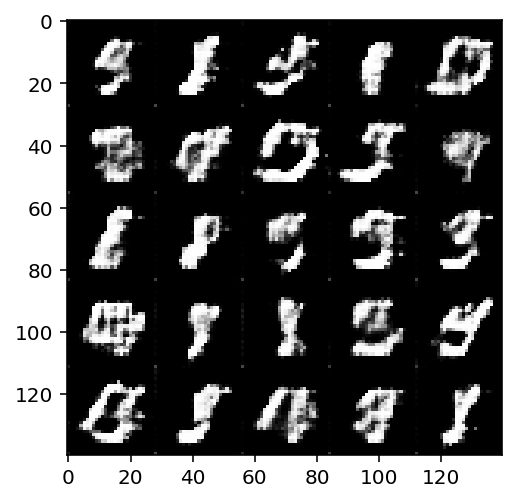

Epoch 1 of 2     Steps: 600     Discriminator Loss: 0.3584     Generator Loss: 1.7919
Epoch 1 of 2     Steps: 700     Discriminator Loss: 0.5225     Generator Loss: 1.3143
Epoch 1 of 2     Steps: 800     Discriminator Loss: 2.3893     Generator Loss: 0.1455
Epoch 1 of 2     Steps: 900     Discriminator Loss: 1.0032     Generator Loss: 1.8950
Epoch 1 of 2     Steps: 1000     Discriminator Loss: 1.4977     Generator Loss: 0.3494
Sample Output:


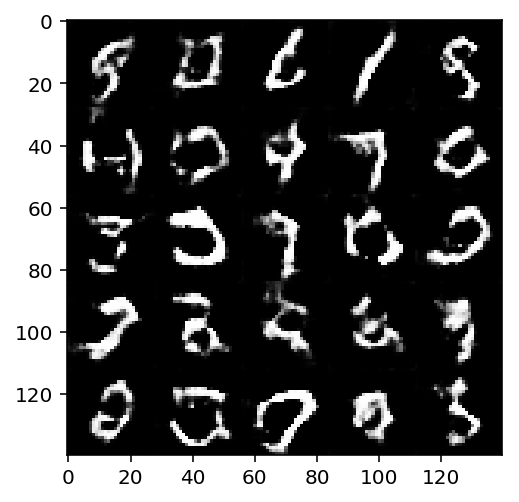

Epoch 1 of 2     Steps: 1100     Discriminator Loss: 0.9067     Generator Loss: 0.9648
Epoch 1 of 2     Steps: 1200     Discriminator Loss: 1.2889     Generator Loss: 0.5191
Epoch 1 of 2     Steps: 1300     Discriminator Loss: 2.0054     Generator Loss: 0.2097
Epoch 1 of 2     Steps: 1400     Discriminator Loss: 1.8005     Generator Loss: 1.3637
Epoch 1 of 2     Steps: 1500     Discriminator Loss: 0.4730     Generator Loss: 1.6247
Sample Output:


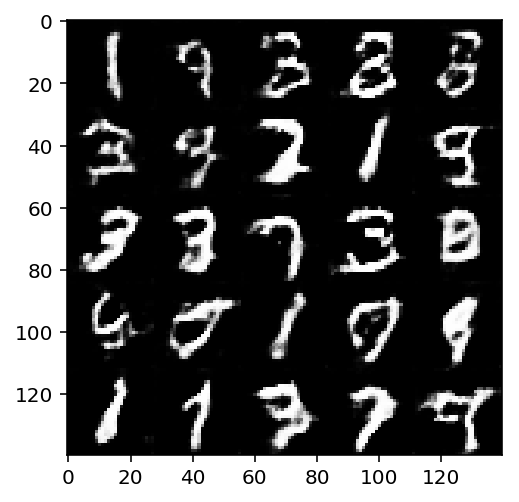

Epoch 1 of 2     Steps: 1600     Discriminator Loss: 1.7917     Generator Loss: 0.2148
Epoch 1 of 2     Steps: 1700     Discriminator Loss: 0.4747     Generator Loss: 1.5208
Epoch 1 of 2     Steps: 1800     Discriminator Loss: 2.2938     Generator Loss: 0.2072
End of Epoch 1  Steps: 1875     Discriminator Loss: 1.0904     Generator Loss: 0.7474
 Sample Output:


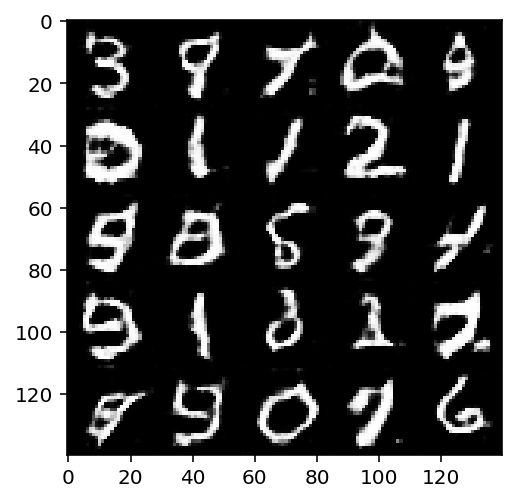

Epoch 2 of 2     Steps: 1900     Discriminator Loss: 1.1383     Generator Loss: 0.6202
Epoch 2 of 2     Steps: 2000     Discriminator Loss: 1.1646     Generator Loss: 0.6200
Sample Output:


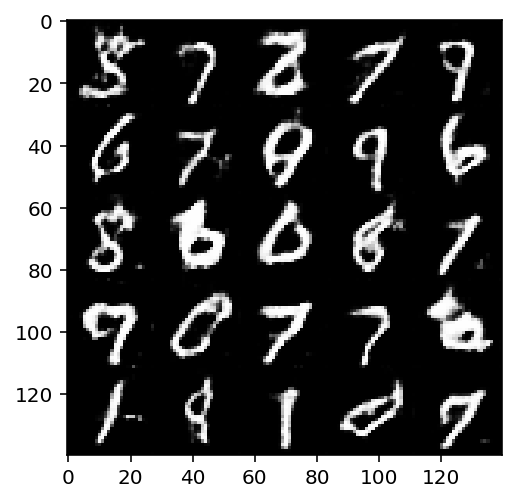

Epoch 2 of 2     Steps: 2100     Discriminator Loss: 0.5850     Generator Loss: 1.6146
Epoch 2 of 2     Steps: 2200     Discriminator Loss: 1.3990     Generator Loss: 0.4078
Epoch 2 of 2     Steps: 2300     Discriminator Loss: 2.2601     Generator Loss: 0.1397
Epoch 2 of 2     Steps: 2400     Discriminator Loss: 0.4738     Generator Loss: 2.4062
Epoch 2 of 2     Steps: 2500     Discriminator Loss: 0.6523     Generator Loss: 1.1895
Sample Output:


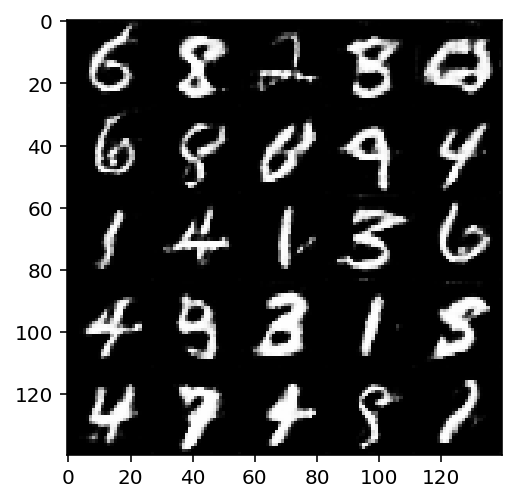

Epoch 2 of 2     Steps: 2600     Discriminator Loss: 1.1630     Generator Loss: 0.4774
Epoch 2 of 2     Steps: 2700     Discriminator Loss: 3.1739     Generator Loss: 0.0865
Epoch 2 of 2     Steps: 2800     Discriminator Loss: 3.0196     Generator Loss: 0.1123
Epoch 2 of 2     Steps: 2900     Discriminator Loss: 2.0650     Generator Loss: 0.1844
Epoch 2 of 2     Steps: 3000     Discriminator Loss: 1.2745     Generator Loss: 0.4915
Sample Output:


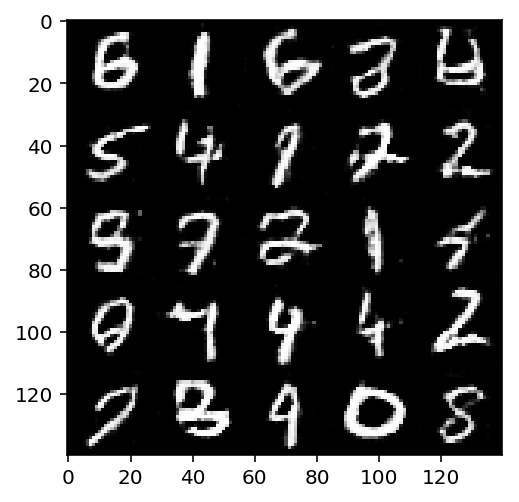

Epoch 2 of 2     Steps: 3100     Discriminator Loss: 2.5968     Generator Loss: 0.1318
Epoch 2 of 2     Steps: 3200     Discriminator Loss: 0.6263     Generator Loss: 1.4493
Epoch 2 of 2     Steps: 3300     Discriminator Loss: 0.6757     Generator Loss: 0.8448
Epoch 2 of 2     Steps: 3400     Discriminator Loss: 1.6737     Generator Loss: 3.3454
Epoch 2 of 2     Steps: 3500     Discriminator Loss: 0.1334     Generator Loss: 3.4634
Sample Output:


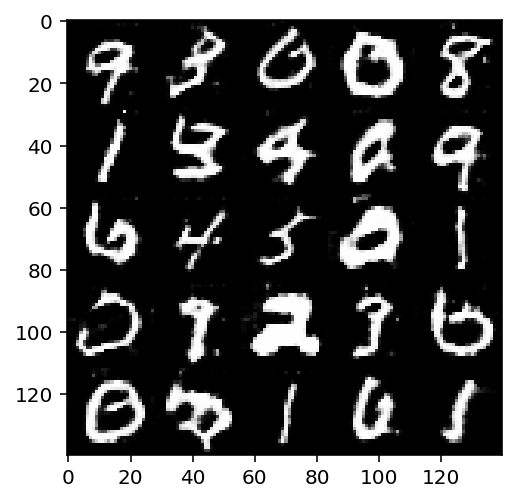

Epoch 2 of 2     Steps: 3600     Discriminator Loss: 2.7757     Generator Loss: 0.1358
Epoch 2 of 2     Steps: 3700     Discriminator Loss: 0.6593     Generator Loss: 1.7282
End of Epoch 2  Steps: 3750     Discriminator Loss: 1.0671     Generator Loss: 2.4526
 Sample Output:


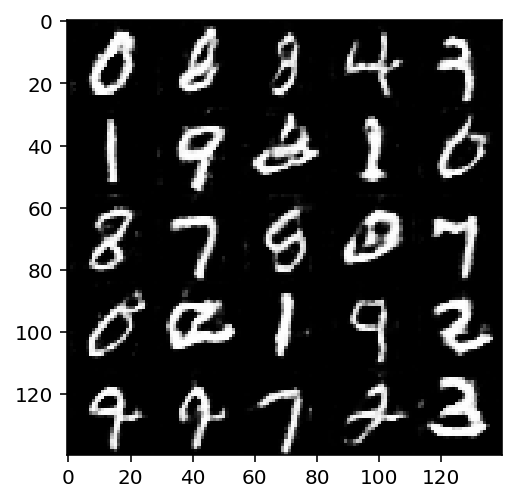

In [84]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### Plot the losses for MNIST

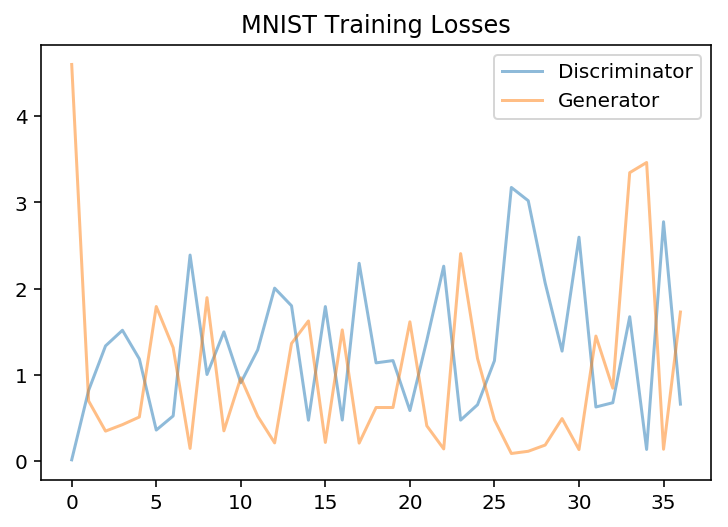

In [85]:
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
pyplot.title("MNIST Training Losses")
pyplot.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1 of 1     Steps: 100     Discriminator Loss: 0.1885     Generator Loss: 3.9552
Epoch 1 of 1     Steps: 200     Discriminator Loss: 0.5272     Generator Loss: 1.1354
Epoch 1 of 1     Steps: 300     Discriminator Loss: 1.1054     Generator Loss: 0.4556
Epoch 1 of 1     Steps: 400     Discriminator Loss: 0.7749     Generator Loss: 1.8894
Epoch 1 of 1     Steps: 500     Discriminator Loss: 0.9126     Generator Loss: 0.6933
Sample Output:


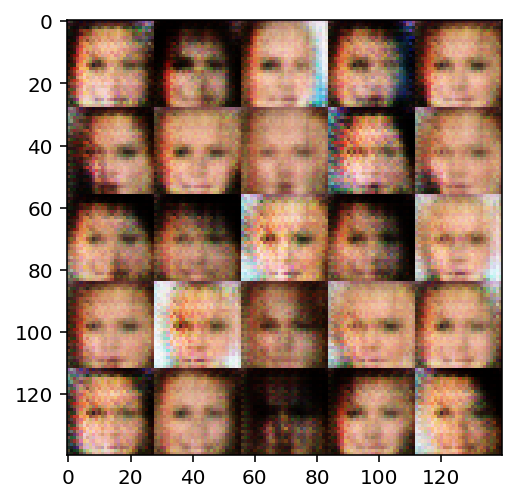

Epoch 1 of 1     Steps: 600     Discriminator Loss: 0.9069     Generator Loss: 0.8838
Epoch 1 of 1     Steps: 700     Discriminator Loss: 0.6950     Generator Loss: 1.2724
Epoch 1 of 1     Steps: 800     Discriminator Loss: 1.3792     Generator Loss: 0.3684
Epoch 1 of 1     Steps: 900     Discriminator Loss: 0.6706     Generator Loss: 1.7817
Epoch 1 of 1     Steps: 1000     Discriminator Loss: 1.2426     Generator Loss: 0.5058
Sample Output:


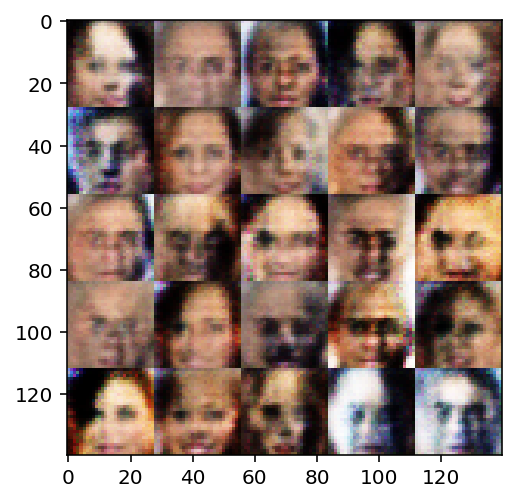

Epoch 1 of 1     Steps: 1100     Discriminator Loss: 0.6247     Generator Loss: 1.3149
Epoch 1 of 1     Steps: 1200     Discriminator Loss: 0.8420     Generator Loss: 1.4984
Epoch 1 of 1     Steps: 1300     Discriminator Loss: 0.5092     Generator Loss: 1.9321
Epoch 1 of 1     Steps: 1400     Discriminator Loss: 0.9239     Generator Loss: 0.8873
Epoch 1 of 1     Steps: 1500     Discriminator Loss: 0.3995     Generator Loss: 2.5064
Sample Output:


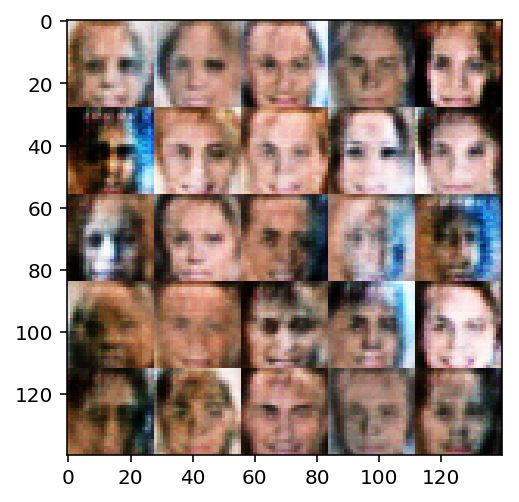

Epoch 1 of 1     Steps: 1600     Discriminator Loss: 0.6691     Generator Loss: 0.8472
Epoch 1 of 1     Steps: 1700     Discriminator Loss: 0.6267     Generator Loss: 1.0984
Epoch 1 of 1     Steps: 1800     Discriminator Loss: 0.9537     Generator Loss: 0.6033
Epoch 1 of 1     Steps: 1900     Discriminator Loss: 0.7679     Generator Loss: 1.1273
Epoch 1 of 1     Steps: 2000     Discriminator Loss: 1.1056     Generator Loss: 0.6643
Sample Output:


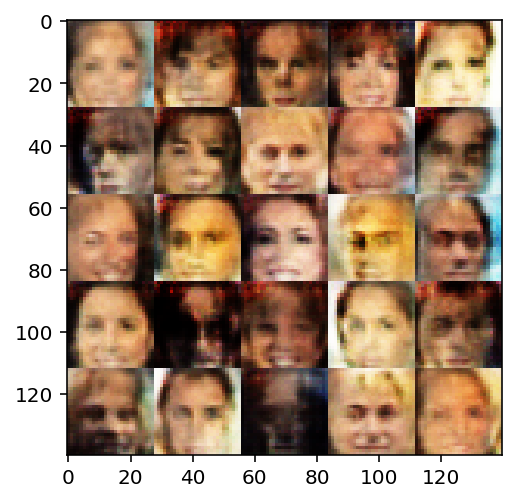

Epoch 1 of 1     Steps: 2100     Discriminator Loss: 0.7365     Generator Loss: 2.1508
Epoch 1 of 1     Steps: 2200     Discriminator Loss: 1.0225     Generator Loss: 2.7270
Epoch 1 of 1     Steps: 2300     Discriminator Loss: 0.7895     Generator Loss: 0.7321
Epoch 1 of 1     Steps: 2400     Discriminator Loss: 0.4528     Generator Loss: 1.3336
Epoch 1 of 1     Steps: 2500     Discriminator Loss: 0.3408     Generator Loss: 1.4557
Sample Output:


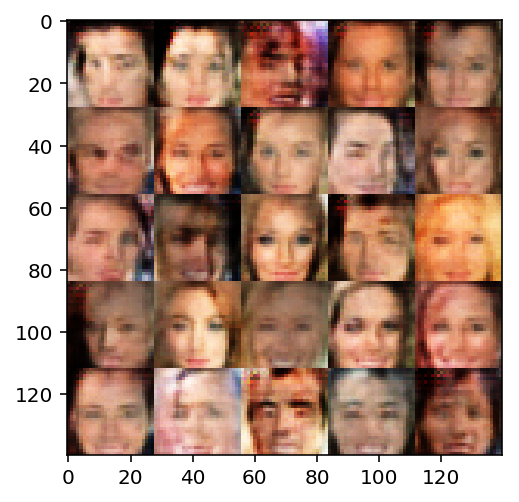

Epoch 1 of 1     Steps: 2600     Discriminator Loss: 0.7500     Generator Loss: 0.8244
Epoch 1 of 1     Steps: 2700     Discriminator Loss: 0.9716     Generator Loss: 0.6389
Epoch 1 of 1     Steps: 2800     Discriminator Loss: 4.3122     Generator Loss: 7.5529
Epoch 1 of 1     Steps: 2900     Discriminator Loss: 0.2864     Generator Loss: 3.0873
Epoch 1 of 1     Steps: 3000     Discriminator Loss: 0.3016     Generator Loss: 1.8224
Sample Output:


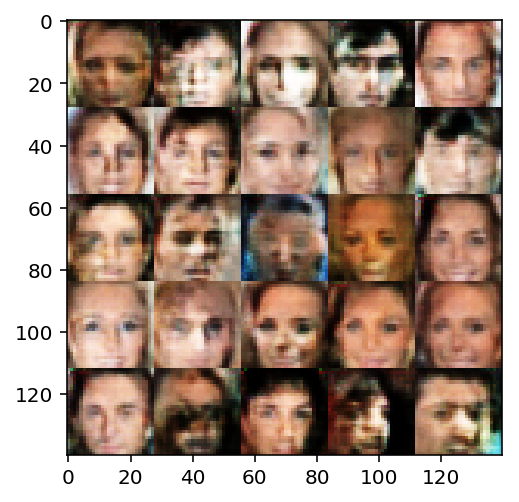

Epoch 1 of 1     Steps: 3100     Discriminator Loss: 1.1744     Generator Loss: 0.4826
Epoch 1 of 1     Steps: 3200     Discriminator Loss: 0.5239     Generator Loss: 1.6302
Epoch 1 of 1     Steps: 3300     Discriminator Loss: 0.4323     Generator Loss: 1.7159
Epoch 1 of 1     Steps: 3400     Discriminator Loss: 0.6450     Generator Loss: 1.2080
Epoch 1 of 1     Steps: 3500     Discriminator Loss: 0.6287     Generator Loss: 2.4208
Sample Output:


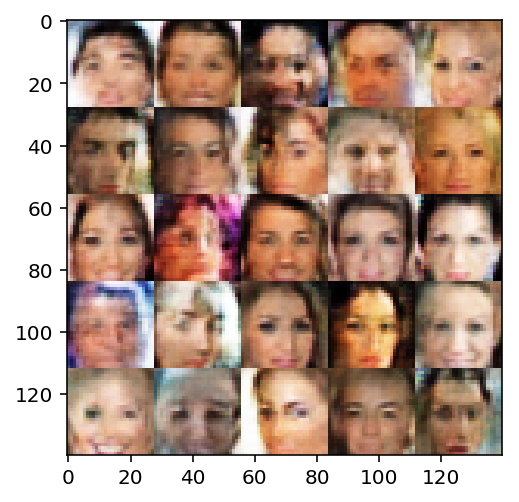

Epoch 1 of 1     Steps: 3600     Discriminator Loss: 0.4985     Generator Loss: 1.2989
Epoch 1 of 1     Steps: 3700     Discriminator Loss: 0.6421     Generator Loss: 1.1014
Epoch 1 of 1     Steps: 3800     Discriminator Loss: 1.1983     Generator Loss: 0.4689
Epoch 1 of 1     Steps: 3900     Discriminator Loss: 0.2586     Generator Loss: 3.9556
Epoch 1 of 1     Steps: 4000     Discriminator Loss: 0.4266     Generator Loss: 1.5190
Sample Output:


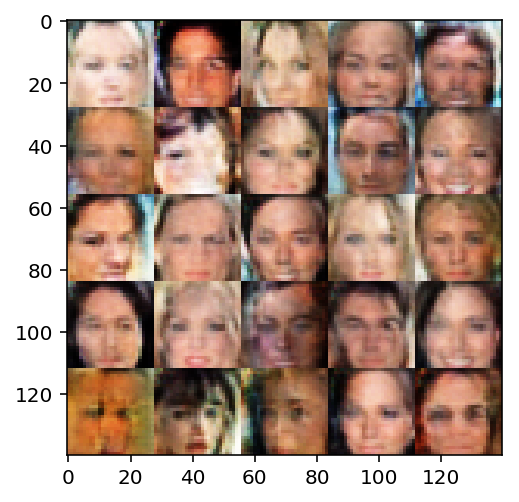

Epoch 1 of 1     Steps: 4100     Discriminator Loss: 0.8941     Generator Loss: 2.9652
Epoch 1 of 1     Steps: 4200     Discriminator Loss: 0.8230     Generator Loss: 0.8529
Epoch 1 of 1     Steps: 4300     Discriminator Loss: 0.6564     Generator Loss: 1.2432
Epoch 1 of 1     Steps: 4400     Discriminator Loss: 0.5035     Generator Loss: 1.1539
Epoch 1 of 1     Steps: 4500     Discriminator Loss: 1.0658     Generator Loss: 0.5603
Sample Output:


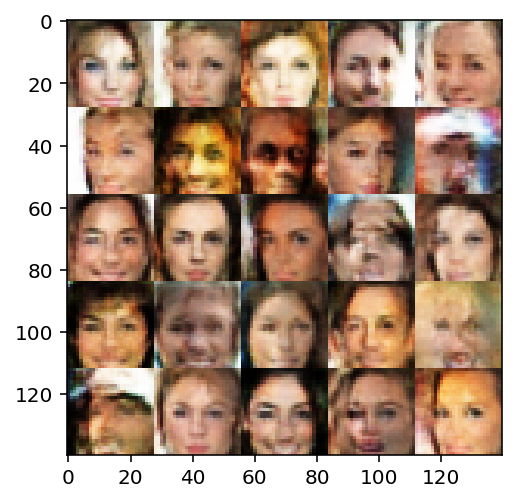

Epoch 1 of 1     Steps: 4600     Discriminator Loss: 0.5355     Generator Loss: 1.3598
Epoch 1 of 1     Steps: 4700     Discriminator Loss: 1.7372     Generator Loss: 4.7202
Epoch 1 of 1     Steps: 4800     Discriminator Loss: 1.1692     Generator Loss: 0.5474
Epoch 1 of 1     Steps: 4900     Discriminator Loss: 0.2905     Generator Loss: 2.5661
Epoch 1 of 1     Steps: 5000     Discriminator Loss: 0.8834     Generator Loss: 0.6470
Sample Output:


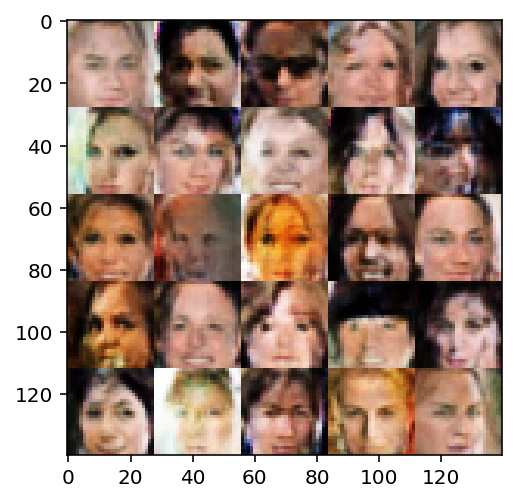

Epoch 1 of 1     Steps: 5100     Discriminator Loss: 1.0238     Generator Loss: 0.5904
Epoch 1 of 1     Steps: 5200     Discriminator Loss: 0.9232     Generator Loss: 0.6218
Epoch 1 of 1     Steps: 5300     Discriminator Loss: 0.2187     Generator Loss: 3.0423
Epoch 1 of 1     Steps: 5400     Discriminator Loss: 0.2330     Generator Loss: 2.2665
Epoch 1 of 1     Steps: 5500     Discriminator Loss: 2.0319     Generator Loss: 4.6782
Sample Output:


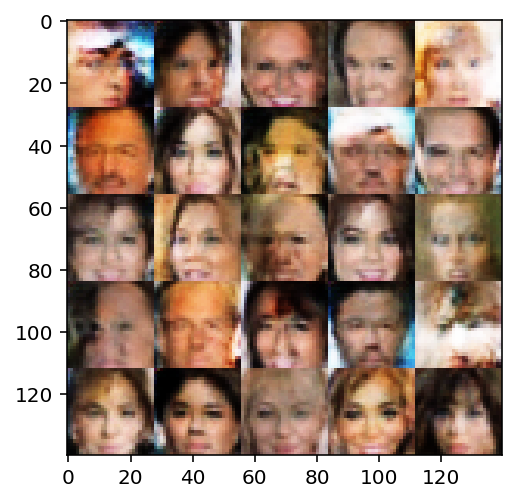

Epoch 1 of 1     Steps: 5600     Discriminator Loss: 0.2531     Generator Loss: 4.8671
Epoch 1 of 1     Steps: 5700     Discriminator Loss: 0.6378     Generator Loss: 1.0159
Epoch 1 of 1     Steps: 5800     Discriminator Loss: 1.0713     Generator Loss: 0.5014
Epoch 1 of 1     Steps: 5900     Discriminator Loss: 0.9492     Generator Loss: 0.6738
Epoch 1 of 1     Steps: 6000     Discriminator Loss: 1.0401     Generator Loss: 0.5536
Sample Output:


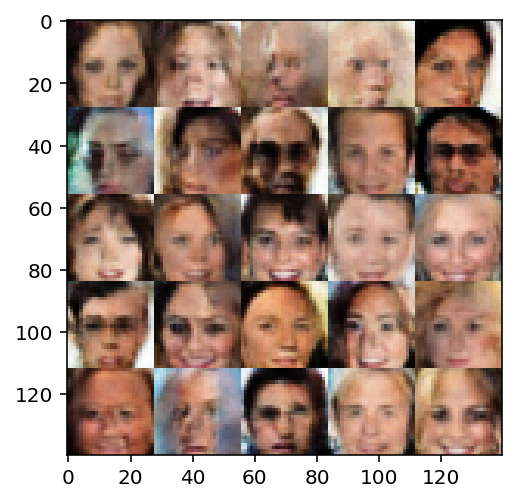

Epoch 1 of 1     Steps: 6100     Discriminator Loss: 1.4907     Generator Loss: 0.3084
Epoch 1 of 1     Steps: 6200     Discriminator Loss: 0.4664     Generator Loss: 2.0402
Epoch 1 of 1     Steps: 6300     Discriminator Loss: 0.5555     Generator Loss: 1.9956
End of Epoch 1  Steps: 6331     Discriminator Loss: 1.4238     Generator Loss: 0.3739
 Sample Output:


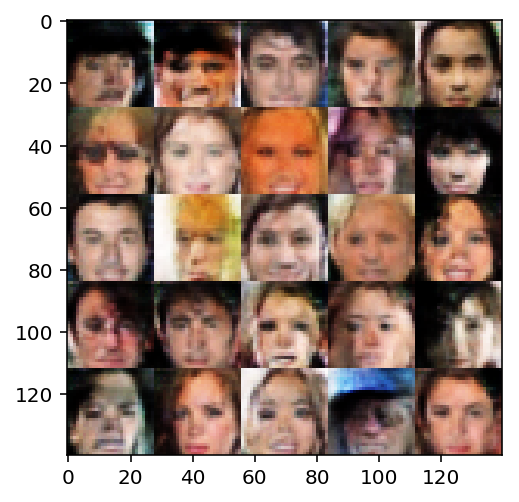

In [87]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Plot the losses for CelebA

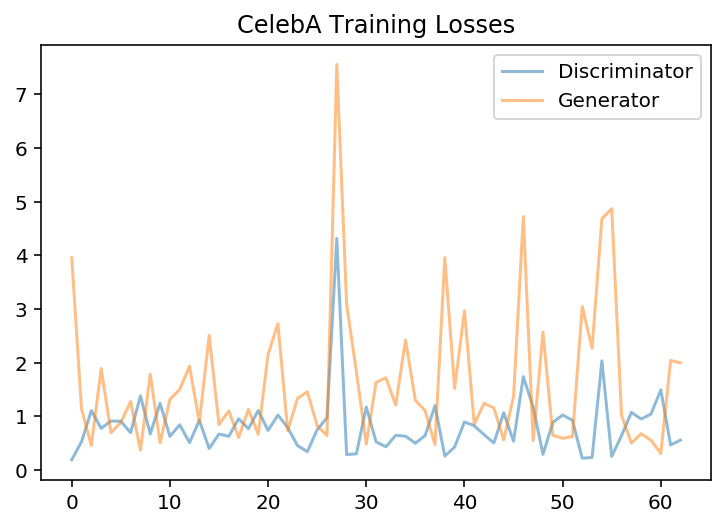

In [88]:
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
pyplot.title("CelebA Training Losses")
pyplot.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.